In [3]:
import pandas as pd
import numpy as np
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
import random


In [4]:
#Load Datasets
airports = pd.read_csv('data/airports.dat', header=None, index_col='Airport ID' ,names=['Airport ID','Airport Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude', 'Longitude' , 'Altitude', 'Timezone', 'DST', 'Tz database timezone', 'Type', 'Source'])

routes = pd.read_csv('data/routes.dat', header=None, names=['Airline', 'Airline ID', 'Source Airport', 'Source Airport ID', 'Destination Airport', 'Destination Airport ID', 'Codeshare', 'Stops', 'Equipment'])

In [7]:
airports.head()

,Airport Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz database timezone,Type,Source
Airport ID,,,,,,,,,,,,,
1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports


In [8]:
routes.head()

,Airline,Airline ID,Source Airport,Source Airport ID,Destination Airport,Destination Airport ID,Codeshare,Stops,Equipment
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2


In [5]:
def plot_graph(G):
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=50, font_size=6, edge_color='gray')
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.show()


In [6]:
def create_flight_graph(airports, routes):
    G = nx.DiGraph()

    for _, airport in airports.iterrows():
        G.add_node(airport['Country'], name = airport['Airport Name'], city = airport['City'])
    
    for _, route in routes.iterrows():
        source_airport = route['Source Airport ID']
        destination_airport = route['Destination Airport ID']

        # Ignore routes that reference airports not registered on the dataset
        if source_airport == '\\N' or destination_airport == '\\N':
            continue
        if int(source_airport) not in airports.index or int(destination_airport) not in airports.index:
            continue

        # Excludes internal flights
        source_country = airports.loc[int(source_airport)]['Country']
        destination_country = airports.loc[int(destination_airport)]['Country']
        if source_country == destination_country:
            continue

        if G.has_edge(source_country, destination_country):
            G[source_country][destination_country]['weight'] += 1
        else:
            G.add_edge(source_country, destination_country, weight=1)
            

    return G

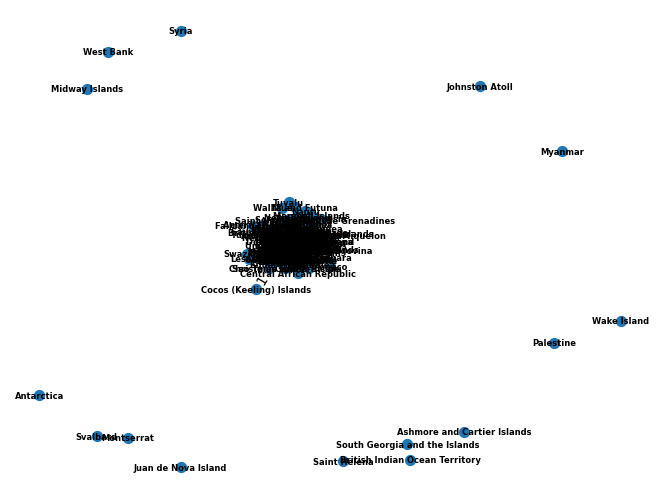

In [7]:
flight_graph = create_flight_graph(airports, routes)
plot_graph(flight_graph)

In [12]:
def get_maximum_degree(graph):
    degrees = dict(graph.degree())
    max_degree = max(degrees.values())
    nodes_with_max_degree = [node for node, degree in degrees.items() if degree == max_degree]
    return max_degree, nodes_with_max_degree

def find_nodes_with_degree_zero(graph, degree_type='in'):
    if degree_type == 'in':
        nodes_with_degree_zero = [node for node in graph.nodes() if graph.in_degree(node) == 0]
    elif degree_type == 'out':
        nodes_with_degree_zero = [node for node in graph.nodes() if graph.out_degree(node) == 0]
    else:
        raise ValueError("Invalid degree_type. Use 'in' or 'out'.")

    return nodes_with_degree_zero

def get_nodes_with_highest_degrees(graph):
    in_degrees = dict(graph.in_degree())
    out_degrees = dict(graph.out_degree())

    max_in_degree_node = max(in_degrees, key=in_degrees.get)
    max_out_degree_node = max(out_degrees, key=out_degrees.get)

    max_in_degree_value = in_degrees[max_in_degree_node]
    max_out_degree_value = out_degrees[max_out_degree_node]

    return [max_in_degree_node, max_in_degree_value], [max_out_degree_node, max_out_degree_value]

def find_heaviest_edge(graph):
    heaviest_edge = max(graph.edges(data=True), key=lambda x: x[2]['weight'])
    return heaviest_edge


def calculate_edge_weight(graph, source, target):
    if graph.has_edge(source, target):
        return graph[source][target]['weight']
    else:
        return None  # Edge does not exist
    
def get_heaviest_edges(graph, n=10):
    edges_with_weights = [(source, target, graph[source][target]['weight']) for source, target in graph.edges()]

    # Sort edges based on weight in descending order
    sorted_edges = sorted(edges_with_weights, key=lambda x: x[2], reverse=True)

    # Return the top n heaviest edges
    return sorted_edges[:n]

# Calculate and print interesting graph metrics

In [13]:
print(f"Number of nodes: {flight_graph.number_of_nodes()}")
print(f"Number of edges: {flight_graph.number_of_edges()}")

Number of nodes: 241
Number of edges: 4561


In [14]:
print("\nAdjacency Matrix:")
print(nx.adjacency_matrix(flight_graph).todense())


Adjacency Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 3 ... 0 0 0]
 [0 3 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [15]:
in0 = find_nodes_with_degree_zero(flight_graph, degree_type='in')
out0 = find_nodes_with_degree_zero(flight_graph, degree_type='out')

print("Nodes with IN dregee 0:")
print(len(in0))
print(in0)
print("Nodes with OUT dregee 0:")
print(len(out0))
print(out0)

Nodes with IN dregee 0:
16
['Saint Helena', 'British Indian Ocean Territory', 'Antarctica', 'West Bank', 'Syria', 'Midway Islands', 'Palestine', 'Montserrat', 'Johnston Atoll', 'Niue', 'South Georgia and the Islands', 'Myanmar', 'Svalbard', 'Wake Island', 'Ashmore and Cartier Islands', 'Juan de Nova Island']
Nodes with OUT dregee 0:
15
['Saint Helena', 'British Indian Ocean Territory', 'Antarctica', 'West Bank', 'Syria', 'Midway Islands', 'Palestine', 'Montserrat', 'Johnston Atoll', 'South Georgia and the Islands', 'Myanmar', 'Svalbard', 'Wake Island', 'Ashmore and Cartier Islands', 'Juan de Nova Island']


In [16]:
max_degree = get_maximum_degree(flight_graph)
print(f"The maximum degree in the graph is: {max_degree}")

maximums_degrees = get_nodes_with_highest_degrees(flight_graph)
print(f"The maximum in degree in the graph is: {maximums_degrees[0]}")
print(f"The maximum out degree in the graph is: {maximums_degrees[1]}")

print(f"Average in-degree: {sum(dict(flight_graph.in_degree()).values()) / flight_graph.number_of_nodes()}")
print(f"Average out-degree: {sum(dict(flight_graph.out_degree()).values()) / flight_graph.number_of_nodes()}")

The maximum degree in the graph is: (229, ['France'])
The maximum in degree in the graph is: ['France', 113]
The maximum out degree in the graph is: ['France', 116]
Average in-degree: 18.925311203319502
Average out-degree: 18.925311203319502


Text(0.5, 1.0, 'Heaviest edges n= 20')

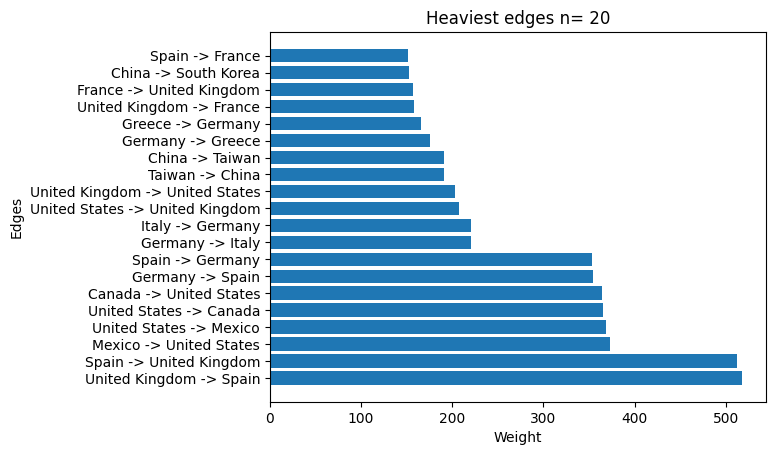

In [17]:
top_edges = get_heaviest_edges(flight_graph, 20)

edges = [f"{edge[0]} -> {edge[1]}" for edge in top_edges]
weights = [edge[2] for edge in top_edges]

plt.barh(edges, weights)
plt.xlabel("Weight")
plt.ylabel("Edges")
plt.title(f"Heaviest edges n= {len(top_edges)}")

In [18]:
weak_connected_components = nx.number_weakly_connected_components(flight_graph)
print(f"Weak connected components: {weak_connected_components}")

strong_connected_components = nx.number_strongly_connected_components(flight_graph)
print(f"Strong connected components: {strong_connected_components}")

Weak connected components: 16
Strong connected components: 17


In [19]:
# TESTAR REMOVER AEORPORTOES OU 
modified_graph = flight_graph.copy()
node_to_remove = max(nx.betweenness_centrality(modified_graph).items(), key=lambda x: x[1])[0]
print(node_to_remove)

United States


In [20]:
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# # Crie uma figura e eixos para o mapa
# fig, ax = plt.subplots(figsize=(15, 10))

# # Desenhe os países no mapa
# world.plot(ax=ax, color='lightgray', edgecolor='black')

# # Mostre o mapa
# plt.show()


In [21]:
def modify_graph(graph, mode, n=20):
    # Copy the graph to avoid modifying the original
    modified_graph = graph.copy()

    # Get the main connected component
    main_component = max(nx.weakly_connected_components(modified_graph), key=len)
    subgraph_nodes = [node for node in modified_graph.nodes if node not in main_component]

    # Remove nodes not connected to the main component
    modified_graph.remove_nodes_from(subgraph_nodes)

    # Initialize lists to store results
    num_components_list = [nx.number_weakly_connected_components(modified_graph)]
    removed_nodes_list = []
    
    data = {'Step': [], 'Removed Node': [], 'Weakly Connected Nodes': []}

    # Iteratively remove nodes based on the specified mode
    for step in range(1, n+1):
        if modified_graph.number_of_nodes() == 0:
            break

        if mode == 'betweeness_centrality':
            node_to_remove = max(nx.betweenness_centrality(modified_graph).items(), key=lambda x: x[1])[0]
        elif mode == 'degree':
            node_to_remove = max(modified_graph.degree, key=lambda x: x[1])[0]
        elif mode == 'random':
            node_to_remove = random.choice(list(modified_graph.nodes))
        else:
            raise ValueError("Invalid mode. Use 'betweeness_centrality', 'degree', or 'random'.")

        # Remove the node and update lists
        modified_graph.remove_node(node_to_remove)
        num_components_list.append(nx.number_weakly_connected_components(modified_graph))
        removed_nodes_list.append(node_to_remove)
        data['Step'].append(step)
        data['Removed Node'].append(node_to_remove)
        data['Weakly Connected Nodes'].append(nx.number_weakly_connected_components(modified_graph))

    result_table = pd.DataFrame(data)
    return result_table

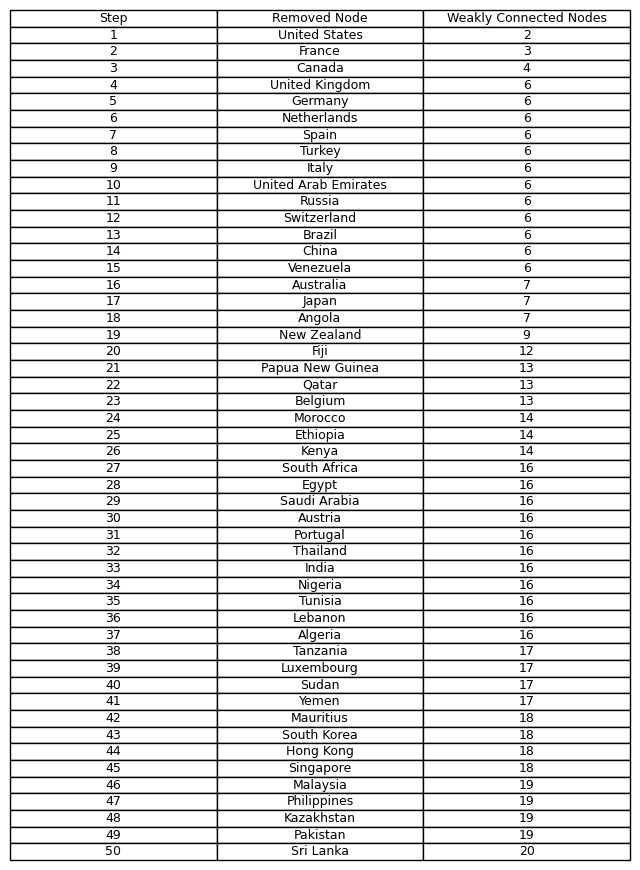

In [22]:
teste = modify_graph(flight_graph, "betweeness_centrality", n=50)

# Ajustar o tamanho da figura para acomodar a tabela
fig, ax = plt.subplots(figsize=(10, 15))  # Ajuste os valores conforme necessário
ax.axis('off')
ax.table(cellText=teste.values,
         colLabels=teste.columns,
         cellLoc='center',
         loc='center')

# Salvar a tabela como imagem em formato SVG
plt.savefig('result_table.svg', format='svg', bbox_inches='tight')
plt.show()

In [23]:
modify_graph(flight_graph, "degree", n=50)

([1,
  2,
  3,
  3,
  3,
  4,
  4,
  4,
  4,
  4,
  4,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  7,
  7,
  7,
  9,
  9,
  10,
  10,
  10,
  10,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  15,
  15,
  15,
  15,
  15],
 ['France',
  'United Kingdom',
  'Germany',
  'Turkey',
  'United States',
  'United Arab Emirates',
  'Netherlands',
  'Italy',
  'Spain',
  'Russia',
  'Canada',
  'China',
  'Qatar',
  'Switzerland',
  'Austria',
  'Belgium',
  'Thailand',
  'Ethiopia',
  'Morocco',
  'Kenya',
  'India',
  'South Africa',
  'Denmark',
  'Malaysia',
  'Greece',
  'South Korea',
  'Panama',
  'Australia',
  'Czech Republic',
  'Saudi Arabia',
  'Poland',
  'Egypt',
  'Hong Kong',
  'Sweden',
  'Portugal',
  'Japan',
  'Singapore',
  'Netherlands Antilles',
  'Norway',
  'Brazil',
  'Nigeria',
  'Ukraine',
  'Dominican Republic',
  'Senegal',
  'Lebanon',
  'Ireland',
  'Israel',
  'Colombia',
  "Cote d'Ivoire",
  'Iran'])

In [24]:
modify_graph(flight_graph, "random", n=50)

([1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 ['Afghanistan',
  'Eritrea',
  'Togo',
  'Oman',
  'Uzbekistan',
  'Iraq',
  'Peru',
  'Israel',
  'Malta',
  'Nepal',
  'North Korea',
  'Anguilla',
  'Libya',
  'American Samoa',
  'Somalia',
  'Netherlands',
  'Nauru',
  'Colombia',
  'Serbia',
  'Sao Tome and Principe',
  'Vanuatu',
  'South Sudan',
  'Trinidad and Tobago',
  'Monaco',
  'Ghana',
  'Palau',
  'Armenia',
  'Cuba',
  'Senegal',
  'Lithuania',
  'Bosnia and Herzegovina',
  'Greece',
  'Cocos (Keeling) Islands',
  'Angola',
  'Tunisia',
  'Namibia',
  'Venezuela',
  'Burundi',
  'United States',
  'Moldova',
  'Spain',
  'Western Sahara',
  "Cote d'Ivoire",
  'Yemen',
  'Tonga',
  'Kenya',
  'Georgia',
  'Russia',
  'Uruguay',
  'Malawi'])